# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

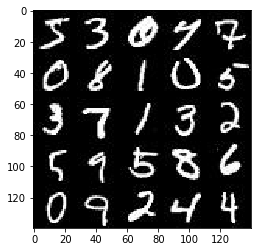

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

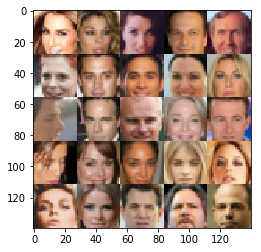

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/ccuulinay/.pyenv/versions/anaconda3-4.2.0/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height ,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [122]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        layer = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        relu = tf.maximum(alpha * layer, layer)
        
        layer = tf.layers.conv2d(relu, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        batch_norm = tf.layers.batch_normalization(layer, training=True)
        relu = tf.maximum(alpha * batch_norm, batch_norm)
        
        layer = tf.layers.conv2d(relu, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        batch_norm = tf.layers.batch_normalization(layer, training=True)
        relu = tf.maximum(alpha * batch_norm, batch_norm)
        
        # print(relu.get_shape().as_list()[1])
        
        flat = tf.reshape(relu, (-1, 4*4*256))
        # logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [123]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # reuse=False
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        layer = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        layer = tf.reshape(layer, (-1, 7, 7, 512))
        batch_norm = tf.layers.batch_normalization(layer, training=is_train)
        relu = tf.maximum(alpha * batch_norm, batch_norm)
        
        layer = tf.layers.conv2d_transpose(relu, 256, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        batch_norm = tf.layers.batch_normalization(layer, training=is_train)
        relu = tf.maximum(alpha * batch_norm, batch_norm)
        
        layer = tf.layers.conv2d_transpose(relu, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        batch_norm = tf.layers.batch_normalization(layer, training=is_train)
        relu = tf.maximum(alpha * batch_norm, batch_norm)
        
        layer = tf.layers.conv2d_transpose(relu, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        # Add upsample from 32x32x3 to 28x28x3
        # logits = tf.image.resize_images(layer, (28, 28))
        logits = layer
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [124]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [125]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [126]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [127]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # saver = tf.train.Saver()
    print_every = 10
    show_every = 100
    
    out_channel_dim = data_shape[3]
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # sample_z = np.random.uniform(-1, 1, size=(50, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                    
                # as data pre-process normal image to -0.5~0.5, so make a double here
                batch_images *= 2
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)

        # saver.save(sess, './checkpoints/generator.ckpt')
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3768... Generator Loss: 2.5090
Epoch 1/2... Discriminator Loss: 0.0032... Generator Loss: 6.1288
Epoch 1/2... Discriminator Loss: 0.0034... Generator Loss: 6.0880
Epoch 1/2... Discriminator Loss: 13.3443... Generator Loss: 28.6141
Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 1.0248
Epoch 1/2... Discriminator Loss: 0.2852... Generator Loss: 2.6384
Epoch 1/2... Discriminator Loss: 0.0521... Generator Loss: 4.0767
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 1.0005
Epoch 1/2... Discriminator Loss: 2.2483... Generator Loss: 2.5858
Epoch 1/2... Discriminator Loss: 2.1738... Generator Loss: 0.2244


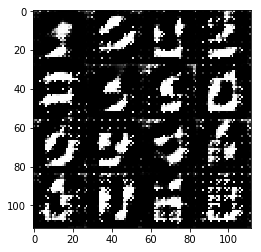

Epoch 1/2... Discriminator Loss: 0.8779... Generator Loss: 1.1613
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.5599
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 0.7789
Epoch 1/2... Discriminator Loss: 2.1183... Generator Loss: 1.2854
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.3841
Epoch 1/2... Discriminator Loss: 2.1356... Generator Loss: 0.2450
Epoch 1/2... Discriminator Loss: 1.7387... Generator Loss: 0.2749
Epoch 1/2... Discriminator Loss: 1.2314... Generator Loss: 0.8283
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 1.3086
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 0.7815


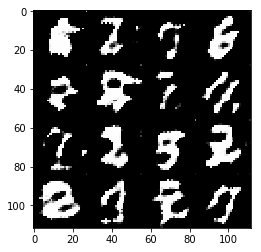

Epoch 1/2... Discriminator Loss: 1.7767... Generator Loss: 0.4764
Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 1.1440
Epoch 1/2... Discriminator Loss: 1.6926... Generator Loss: 0.3301
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.5104
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.4725
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 1.1448
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 1.2933
Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 1.2125
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 1.0434
Epoch 1/2... Discriminator Loss: 1.4605... Generator Loss: 0.4358


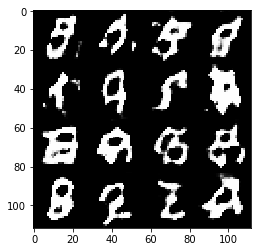

Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 0.9095
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 0.8336
Epoch 1/2... Discriminator Loss: 1.7310... Generator Loss: 1.7111
Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 1.7390
Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 0.7256
Epoch 1/2... Discriminator Loss: 1.2082... Generator Loss: 1.2101
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.3782
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.4947


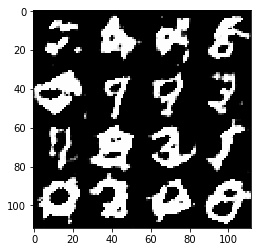

Epoch 1/2... Discriminator Loss: 1.4655... Generator Loss: 1.9765
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.3584
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 1.2865
Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.5614... Generator Loss: 2.1821
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 1.0058
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 1.5176... Generator Loss: 1.8564


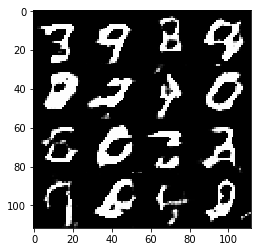

Epoch 2/2... Discriminator Loss: 1.0364... Generator Loss: 0.8910
Epoch 2/2... Discriminator Loss: 1.1775... Generator Loss: 1.1420
Epoch 2/2... Discriminator Loss: 1.3127... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 1.5844... Generator Loss: 0.3580
Epoch 2/2... Discriminator Loss: 1.1329... Generator Loss: 1.4278
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 1.2964
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 1.2722
Epoch 2/2... Discriminator Loss: 0.9730... Generator Loss: 1.1521
Epoch 2/2... Discriminator Loss: 1.7043... Generator Loss: 1.4335
Epoch 2/2... Discriminator Loss: 1.0730... Generator Loss: 0.7107


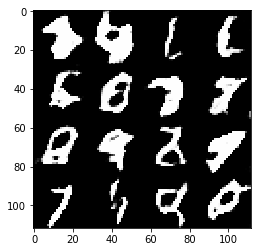

Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.4384
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 1.2235
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.9187
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.7083
Epoch 2/2... Discriminator Loss: 1.4633... Generator Loss: 0.3855
Epoch 2/2... Discriminator Loss: 1.6411... Generator Loss: 0.3507
Epoch 2/2... Discriminator Loss: 1.2610... Generator Loss: 1.3444
Epoch 2/2... Discriminator Loss: 1.0503... Generator Loss: 0.7735
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.6034


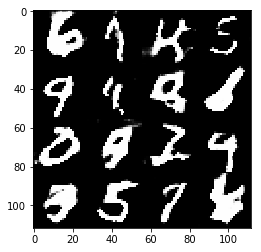

Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.0444... Generator Loss: 1.2237
Epoch 2/2... Discriminator Loss: 1.1105... Generator Loss: 1.6047
Epoch 2/2... Discriminator Loss: 1.0688... Generator Loss: 1.1398
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.1941... Generator Loss: 0.5990
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 0.6677
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.6310
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 1.1717... Generator Loss: 0.6043


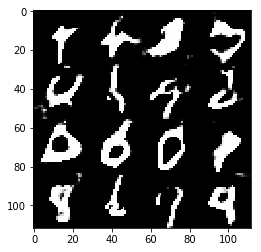

Epoch 2/2... Discriminator Loss: 1.1557... Generator Loss: 0.8269
Epoch 2/2... Discriminator Loss: 1.5573... Generator Loss: 1.9263
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 1.9612
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.5139
Epoch 2/2... Discriminator Loss: 1.2982... Generator Loss: 1.1440
Epoch 2/2... Discriminator Loss: 1.4562... Generator Loss: 1.7748
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.0689
Epoch 2/2... Discriminator Loss: 1.4858... Generator Loss: 2.1614
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 1.8608


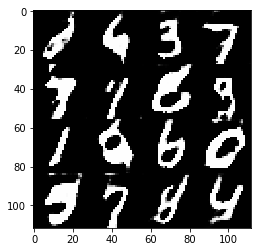

Epoch 2/2... Discriminator Loss: 1.2007... Generator Loss: 0.7440
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 1.0924
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.4078


In [128]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9052... Generator Loss: 0.2674
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 2.0192
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.5253
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 2.3198
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 1.6709
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.4315
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 3.0869
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 3.7645
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 3.1538


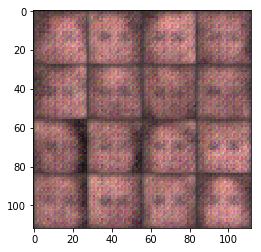

Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 4.4247
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 4.0687
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 3.8479
Epoch 1/1... Discriminator Loss: 0.3634... Generator Loss: 3.0951
Epoch 1/1... Discriminator Loss: 0.3684... Generator Loss: 4.3320
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 4.4803
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 4.0316
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 3.9242
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 3.3030
Epoch 1/1... Discriminator Loss: 0.2129... Generator Loss: 3.1352


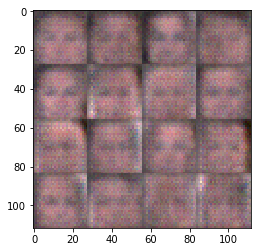

Epoch 1/1... Discriminator Loss: 0.4476... Generator Loss: 3.0636
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 4.5680
Epoch 1/1... Discriminator Loss: 0.3048... Generator Loss: 3.1355
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 3.1035
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 4.1718
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 3.5587
Epoch 1/1... Discriminator Loss: 0.4336... Generator Loss: 5.4501
Epoch 1/1... Discriminator Loss: 1.5483... Generator Loss: 2.9439
Epoch 1/1... Discriminator Loss: 0.1549... Generator Loss: 3.3416
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 4.3810


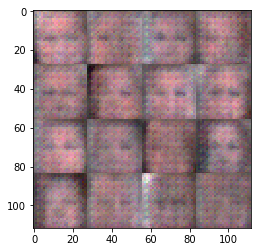

Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 3.1756
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.3460
Epoch 1/1... Discriminator Loss: 0.3345... Generator Loss: 1.7341
Epoch 1/1... Discriminator Loss: 0.3520... Generator Loss: 1.6325
Epoch 1/1... Discriminator Loss: 0.1370... Generator Loss: 4.4408
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 3.4827
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 3.7165
Epoch 1/1... Discriminator Loss: 0.1667... Generator Loss: 2.9903


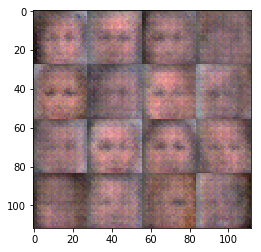

Epoch 1/1... Discriminator Loss: 0.1581... Generator Loss: 3.2644
Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 1.4013
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 0.9743
Epoch 1/1... Discriminator Loss: 2.4737... Generator Loss: 0.1226
Epoch 1/1... Discriminator Loss: 0.5470... Generator Loss: 3.5440
Epoch 1/1... Discriminator Loss: 0.2789... Generator Loss: 2.8957
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 2.7416
Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 1.1919
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.4072


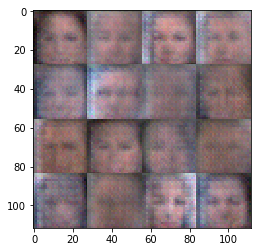

Epoch 1/1... Discriminator Loss: 0.8256... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 0.3154... Generator Loss: 2.9887
Epoch 1/1... Discriminator Loss: 0.4598... Generator Loss: 1.5859
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 3.1859
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 2.5469
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 1.7982... Generator Loss: 0.2379
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 0.2682... Generator Loss: 2.1741


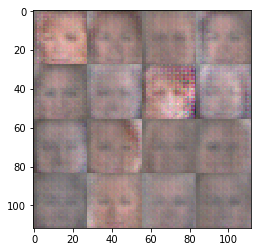

Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.6772... Generator Loss: 0.2628
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 2.1965
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 1.4065
Epoch 1/1... Discriminator Loss: 2.0213... Generator Loss: 0.1768
Epoch 1/1... Discriminator Loss: 0.6707... Generator Loss: 1.1104
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 0.9774
Epoch 1/1... Discriminator Loss: 0.3038... Generator Loss: 3.7464
Epoch 1/1... Discriminator Loss: 0.5325... Generator Loss: 2.0438
Epoch 1/1... Discriminator Loss: 0.3199... Generator Loss: 2.4398


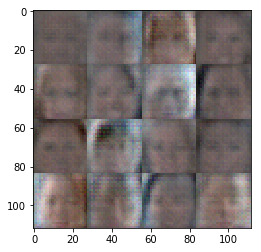

Epoch 1/1... Discriminator Loss: 2.1503... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 3.6748
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 1.7232
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 2.8768
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 4.8806
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 3.4057
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.4370
Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 3.8927
Epoch 1/1... Discriminator Loss: 0.2599... Generator Loss: 2.6126


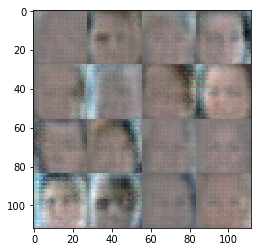

Epoch 1/1... Discriminator Loss: 1.8826... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 2.3495
Epoch 1/1... Discriminator Loss: 0.2035... Generator Loss: 2.9006
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.3500
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 1.2232
Epoch 1/1... Discriminator Loss: 0.7319... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 1.2730


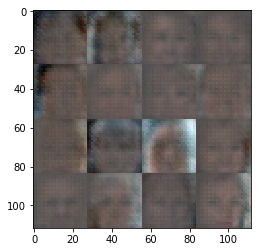

Epoch 1/1... Discriminator Loss: 0.2284... Generator Loss: 3.2112
Epoch 1/1... Discriminator Loss: 0.2794... Generator Loss: 3.0040
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 0.4623... Generator Loss: 3.2915
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 1.9806
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 1.2691
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 3.4844
Epoch 1/1... Discriminator Loss: 2.2919... Generator Loss: 1.6832
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 1.6710
Epoch 1/1... Discriminator Loss: 0.2911... Generator Loss: 2.6029


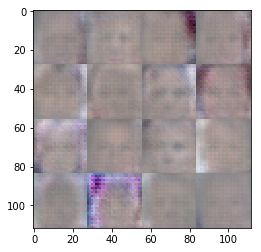

Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 1.6975
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 3.5121
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 2.3079
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 2.2076
Epoch 1/1... Discriminator Loss: 0.3123... Generator Loss: 2.2760
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.0307


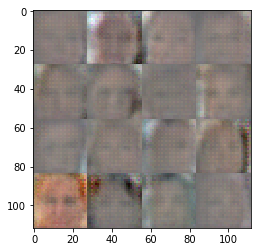

Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 0.5554... Generator Loss: 1.9849
Epoch 1/1... Discriminator Loss: 0.3271... Generator Loss: 2.6424
Epoch 1/1... Discriminator Loss: 0.3139... Generator Loss: 3.2613
Epoch 1/1... Discriminator Loss: 2.2150... Generator Loss: 0.1558
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 3.7003
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 1.6850
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.1496
Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 2.7441
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 3.1547


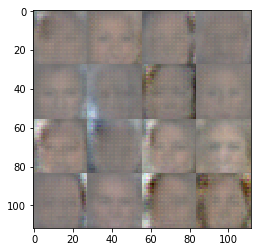

Epoch 1/1... Discriminator Loss: 0.2334... Generator Loss: 3.1208
Epoch 1/1... Discriminator Loss: 2.6552... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 3.4192
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 2.6636
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 0.2656... Generator Loss: 3.2428
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 1.7418
Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 0.2526... Generator Loss: 3.0335


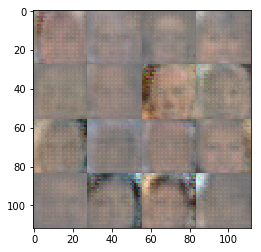

Epoch 1/1... Discriminator Loss: 2.0122... Generator Loss: 0.1646
Epoch 1/1... Discriminator Loss: 0.4815... Generator Loss: 1.9721
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 0.2912... Generator Loss: 2.4980
Epoch 1/1... Discriminator Loss: 0.4227... Generator Loss: 1.3398
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.1374
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 2.4835
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.1240


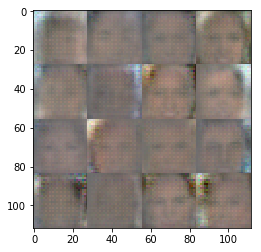

Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 2.0241
Epoch 1/1... Discriminator Loss: 0.2706... Generator Loss: 2.0429
Epoch 1/1... Discriminator Loss: 0.4698... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 1.5131
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 2.8765
Epoch 1/1... Discriminator Loss: 1.5433... Generator Loss: 0.3594
Epoch 1/1... Discriminator Loss: 0.4675... Generator Loss: 3.3031
Epoch 1/1... Discriminator Loss: 0.3283... Generator Loss: 3.1672
Epoch 1/1... Discriminator Loss: 0.1646... Generator Loss: 2.4404
Epoch 1/1... Discriminator Loss: 0.2239... Generator Loss: 2.5618


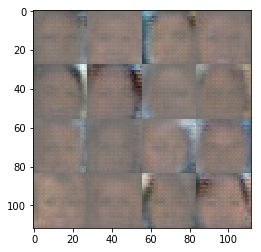

Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.5849
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 1.0124
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.0319


In [130]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.